In [1]:
import sys
import os
sys.path.append('../')

from dataset.data import split_data
from question1 import eigen
from question2 import inc_pca

from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
from sklearn.neighbors import KNeighborsClassifier

1. Further divide the training data equally into four subsets, each with 104 images

In [11]:
data_path = "../dataset/face.mat"
train_data, train_label, test_data, test_label = split_data(data_path)

# 1. additional seperation of the training data
train_data1 = train_data[:, 0::4]
train_data2 = train_data[:, 1::4]
train_data3 = train_data[:, 2::4]
train_data4 = train_data[:, 3::4]

train_label1 = train_label[0::4]
train_label2 = train_label[1::4]
train_label3 = train_label[2::4]
train_label4 = train_label[3::4]

train_data = np.hstack([train_data1, train_data2, train_data3, train_data4])
train_label = np.concatenate([train_label1, train_label2, train_label3, train_label4])

2. Perform Incremental PCA, and compare it with the counterpart i.e. batch PCA, and PCA 
trained only by the first subset

    training time, reconstruction error, face recognition accuracy (using NN classification).   
    * time 측정 시 eigen-decomposition 제외 무시해도 됨 -> eigen-decomposition 부분에만 time을 달면 됨

In [21]:
# Incremental PCA: calculate batch time and memory, average of 10-time execution
total_time = []
batch_time = []
combine_time = []
memory_usage = []
for i in range (10):
    ipca = inc_pca.IncrementalPCA(n_components=50, check_performance = True)
    eigvals, eigvecs = ipca.fit(train_data, 104)
    batch_time.append(ipca.new_batch_t)
    combine_time.append(ipca.combine_t)
    memory_usage.append(ipca.combine_m)

New batch eigen decomposition time: 0.04666 sec
[incremental_pca_eigen_decomposition] memory usage:  201.17188 MB
New batch eigen decomposition time: 0.06209 sec
[incremental_pca_eigen_decomposition] memory usage:  304.47656 MB
combined covariance matrix decomposition time: 0.01649 sec
[incremental_pca_eigen_decomposition] memory usage:  357.09375 MB
result shape:  (2576, 50) (50,)
New batch eigen decomposition time: 0.04029 sec
[incremental_pca_eigen_decomposition] memory usage:  302.42969 MB
combined covariance matrix decomposition time: 0.02028 sec
[incremental_pca_eigen_decomposition] memory usage:  355.04688 MB
result shape:  (2576, 50) (50,)
New batch eigen decomposition time: 0.03997 sec
[incremental_pca_eigen_decomposition] memory usage:  302.42969 MB
combined covariance matrix decomposition time: 0.04046 sec
[incremental_pca_eigen_decomposition] memory usage:  355.05078 MB
result shape:  (2576, 50) (50,)
New batch eigen decomposition time: 0.03836 sec
[incremental_pca_eigen_de

In [19]:
print("time")
print(ipca.new_batch_t)
print(ipca.combine_t)
print("mem")
print(ipca.new_batch_m)
print(ipca.combine_m)

#print(ipca.eigenval)

time
[0.02951359748840332, 0.02308940887451172, 0.02816033363342285, 0.03240513801574707]
[0.0, 0.029072046279907227, 0.021047353744506836, 0.023463726043701172]
mem
[199.20703125, 303.1640625, 302.4296875, 302.4296875]
[0.0, 356.09375, 355.046875, 355.046875]


In [22]:
# average calculation: 여기서 total time이 training time으로 쓰일 수 있음
batch_time = np.array(batch_time)
combine_time = np.array(combine_time)
memory_usage = np.array(memory_usage)

batch_time_avg = batch_time.mean(axis=0)
combine_time_avg = combine_time[:, 1:].mean(axis=0)
combine_time_avg = np.concatenate(([0.0], combine_time_avg), axis=0)
total_time = batch_time_avg + combine_time_avg

memory_usage_avg = memory_usage.mean(axis=0)

print(batch_time_avg)
print(combine_time_avg)
print(total_time)
print(memory_usage_avg)

[0.04676313 0.03983629 0.0418273  0.03831799]
[0.         0.02973506 0.0295357  0.03628094]
[0.04676313 0.06957135 0.071363   0.07459893]
[  0.         356.23828125 355.04453125 355.05078125]


-> how accurate your incremental method is, what important parameters in the method are???

In [25]:
mean_face = np.mean(train_data, axis=1).reshape(-1, 1)
val_batch, vec_batch = eigen.pca(train_data, mean_face)
print(val_batch[:5])

batch_size = 104

pca_time = []
pca_mem = []
for i in range (4):
    cur_train_data = train_data[:, :(i+1) * 104]
    cur_train_label = train_label[:(i+1) * 104]
    mean_face = np.mean(cur_train_data, axis=1).reshape(-1, 1)
    val_batch, vec_batch, t, m = eigen.pca_perf(cur_train_data, mean_face)
    pca_time.append(t)
    pca_mem.append(m)
print(pca_time)
print(pca_mem)

[916420.71213223 536260.72828332 450658.20970479 253402.13754361
 221169.88932295]
 0.03208 sec
[pca] memory usage:  210.00391 MB
 0.14990 sec
[pca] memory usage:  208.28906 MB
 0.45804 sec
[pca] memory usage:  214.08594 MB
 1.11707 sec
[pca] memory usage:  221.54688 MB
[0.03207969665527344, 0.1499018669128418, 0.4580376148223877, 1.1170709133148193]
[210.00390625, 208.2890625, 214.0859375, 221.546875]


In [64]:
# saving
# 결과 제대로 나왔을때만 키기
io.savemat('inc-batch-timemem.mat', {'inc_time':total_time, 'inc_batch_time': batch_time_avg,
                                     'inc_comb_time': combine_time_avg, 'inc_mem': memory_usage_avg,
                                     'batch_time': pca_time, 'batch_mem': pca_mem})


(4,) (4,)


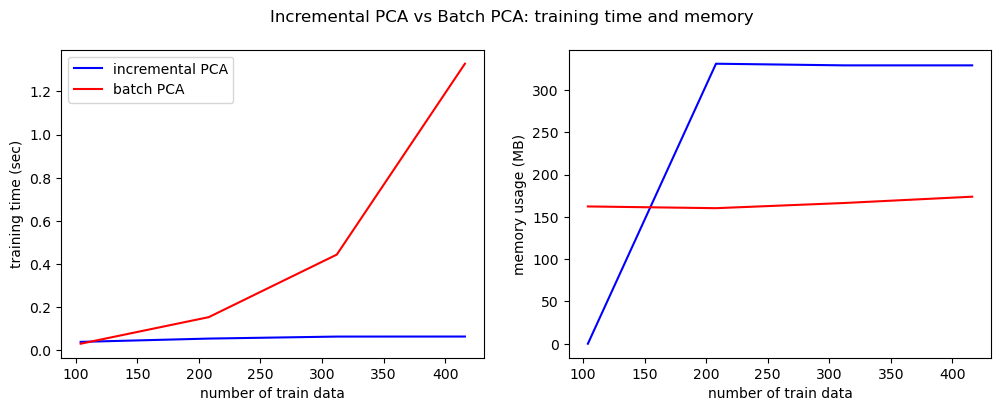

In [89]:
# 1. batch vs inc PCA, time and memory
base_dir = os.getcwd()  
full_data_path = os.path.join(base_dir, "./inc-batch-timemem.mat")
file = io.loadmat(full_data_path)
inc_time = np.array(file["inc_time"]).flatten()
inc_mem = np.array(file["inc_mem"]).flatten()
batch_time = np.array(file["batch_time"]).flatten()
batch_mem = np.array(file["batch_mem"]).flatten()

graph = plt.figure(figsize=(12, 4))
ax1 = graph.add_subplot(121)
ax2 = graph.add_subplot(122)
X = np.arange(104, 417, 104)
print(X.shape, inc_time.shape)

ax1.plot(X, inc_time, color='b', label='incremental PCA')
ax1.plot(X, batch_time, color='r', label='batch PCA')
ax1.set_xlabel('number of train data')
ax1.set_ylabel('training time (sec)')
ax1.legend()

ax2.plot(X, inc_mem, color='b', label='incremental PCA')
ax2.plot(X, batch_mem, color='r', label='batch PCA')
ax2.set_xlabel('number of train data')
ax2.set_ylabel('memory usage (MB)')

plt.suptitle('Incremental PCA vs Batch PCA: training time and memory')
# 결과 제대로 나왔을때만 키기
#plt.savefig('q2-fig1', dpi=300)

In [6]:
pca_mean = []
pca_eigenvec = []
pca_eigenval = []
for i in range (4):
    cur_train_data = train_data[:, :(i+1) * 104]
    cur_train_label = train_label[:(i+1) * 104]
    mean_face = np.mean(cur_train_data, axis=1).reshape(-1, 1)
    val_batch, vec_batch = eigen.pca(cur_train_data, mean_face)
    pca_mean.append(mean_face)
    pca_eigenvec.append(vec_batch)
    pca_eigenval.append(val_batch)

ipca = inc_pca.IncrementalPCA(n_components=50, step_save=True)
eigvals, eigvecs = ipca.fit(train_data, 104)

result shape:  (2576, 50) (50,)
result shape:  (2576, 50) (50,)
result shape:  (2576, 50) (50,)


In [10]:
# 2. batch vs inc PCA, eigenvector/mean cosine similarity by first 50 components
#idx 0, 1, 2, 3에 각각 104, 208, 312, 416 train data에서 similarity가 들어감
from sklearn.metrics.pairwise import cosine_similarity

mean_similarity = []
vec_similarity = []
for i in range (4):
    cur_batch_mean = pca_mean[i]
    cur_batch_vec = pca_eigenvec[i][:,:50]
    cur_inc_mean = ipca.step_mean[i]
    cur_inc_vec = ipca.step_eigenvec[i]

    mean_similarity.append(cosine_similarity(cur_batch_mean.T, cur_inc_mean.T))
    vec_similarity.append(np.diag(cosine_similarity(cur_batch_vec.T, cur_inc_vec.T)))

mean_similarity = np.array(mean_similarity).flatten()
vec_similarity = abs(np.array(vec_similarity)).mean(axis=1)

# 1, 2, 3, 4 batch에서 mean / eigenvector cosine similarity
print(mean_similarity, vec_similarity)

[1. 1. 1. 1.] [1.         0.90095859 0.89137504 0.8561277 ]


In [ ]:
# 3. batch vs inc PCA, reconstruction error by first 50 components


In [ ]:
# 4. batch vs inc PCA, KNN classification accuracy by first 50 components


In [ ]:
# draw graph of 2, 3, 4
graph = plt.figure(figsize=(12, 4))
ax1 = graph.add_subplot(121)
ax2 = graph.add_subplot(122)
X = np.arange(104, 417, 104)
print(X.shape, inc_time.shape)

ax1.plot(X, inc_time, color='b', label='incremental PCA')
ax1.plot(X, batch_time, color='r', label='batch PCA')
ax1.set_xlabel('number of train data')
ax1.set_ylabel('training time (sec)')
ax1.legend()

ax2.plot(X, inc_mem, color='b', label='incremental PCA')
ax2.plot(X, batch_mem, color='r', label='batch PCA')
ax2.set_xlabel('number of train data')
ax2.set_ylabel('memory usage (MB)')

plt.suptitle('Incremental PCA vs Batch PCA: training time and memory')
plt.savefig('q2-fig1', dpi=300)

In [23]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload